## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jul 25 20:13:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Grounding DINO and Segment Anything Model

Our project will use two groundbreaking designs - [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) - for zero-shot detection and [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) - for converting boxes into segmentations. We have to install them first.


In [3]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 401 (delta 58), reused 50 (delta 50), pack-reused 316
Receiving objects: 100% (401/401), 12.85 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (204/204), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.0 MB/s eta 0:00:00


In [4]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-6zzx3ztx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-6zzx3ztx
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=04c4ff26ec12dfc095eb8307302f72704ad3e245d2ca6e3c70184e10f1d8fef8
  Stored in directory: /tmp/pip-ephem-wheel-cache-qrbhz9l9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


**NOTE:** To glue all the elements of our demo together we will use the [`supervision`](https://github.com/roboflow/supervision) pip package, which will help us **process, filter and visualize our detections as well as to save our dataset**. A lower version of the `supervision` was installed with Grounding DINO. However, in this demo we need the functionality introduced in the latest versions. Therefore, we uninstall the current `supervsion` version and install version `0.6.0`.



In [5]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
0.6.0


**NOTE:** At the end of the tutorial we will upload our annotations to [Roboflow](roboflow.com). To automate this process with the API, let's install the `roboflow` pip package.

In [6]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.


### Download Grounding DINO Model Weights

To run Grounding DINO we need two files - configuration and model weights. The configuration file is part of the [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) repository, which we have already cloned. The weights file, on the other hand, we need to download. We write the paths to both files to the `GROUNDING_DINO_CONFIG_PATH` and `GROUNDING_DINO_CHECKPOINT_PATH` variables and verify if the paths are correct and the files exist on disk.

In [7]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [8]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [9]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


### Download Segment Anything Model (SAM) Weights

As with Grounding DINO, in order to run SAM we need a weights file, which we must first download. We write the path to local weight file to `SAM_CHECKPOINT_PATH` variable and verify if the path is correct and the file exist on disk.

In [10]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [11]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load models

In [12]:
import numpy as np
import random
from google.colab.patches import cv2_imshow

In [13]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Grounding DINO Model

In [14]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


### Load Segment Anything Model (SAM)

In [15]:
SAM_ENCODER_VERSION = "vit_h"

In [16]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

## Object Detection

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [19]:
import cv2
import supervision as sv

def detect(image, classes):
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=classes),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    return detections

BOX_TRESHOLD = 0.4
TEXT_TRESHOLD = 0.25
CLASSES=[]

## Read Video

In [21]:
import cv2
import numpy as np

# access to google drive if needed, otherwise comment this out
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive/')
cwd = '/content/drive/My Drive/GPT/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
def read_video(path, scale=5, second_per_frame=2):
    cap = cv2.VideoCapture(path)

    video_fps = cap.get(cv2.CAP_PROP_FPS),
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

    video = []
    frame_counter = 0
    frame_per_sec = int(round(video_fps[0]))*second_per_frame

    while True:
        ret, frame = cap.read()
        if not ret: break # break if no next frame

        if frame_counter % frame_per_sec == 0:
            res_frame = cv2.resize(frame, dsize=(int(width//scale), int(height//scale)), interpolation=cv2.INTER_CUBIC)
            # cv2_imshow(res_frame) # show frame
            video.append(res_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'): # on press of q break
            break
        frame_counter += 1

    # release and destroy windows
    cap.release()
    cv2.destroyAllWindows()
    return np.array(video)

In [23]:
def annotate(image, detections, classes):
    box_annotator = sv.BoxAnnotator()
    labels = [
        f"{classes[class_id] if class_id is not None else None} {confidence:0.2f}"
        for _, _, confidence, class_id, _ in detections
    ]

    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    %matplotlib inline
    sv.plot_image(annotated_frame, (16, 16))

def get_prop_traj(prop, video, annot=True):
    classes = [prop]
    traj = []
    for v in video:
        d = detect(v, classes)
        if len(d.class_id) > 0:
            traj.append(np.round(np.max(d.confidence), 2))
        else:
            traj.append(0)
        if annot:
            annotate(v, d, classes)
    return traj

def sigmoid(x, k=1, x0=0):
  return 1 / (1 + np.exp(-k * (x-x0) ))

def mapping(conf_arr, true_threshold=0.66, false_threshold=0.38):
    probs = []
    for conf in conf_arr:
        if conf >= true_threshold:
            probs.append(1)
        elif conf <= false_threshold:
            probs.append(0)
        else:
            probs.append(round(sigmoid(conf, k=50, x0=0.56), 2))
    return probs

def get_probabilities(props, video):
    confs = []
    for p in props:
        confs.append(get_prop_traj(p, video))
    print(confs)
    probabilities = []
    for c in confs:
        probabilities.append(mapping(c))
    return probabilities

In [24]:
class State:
    def __init__(self, idx, frame_num, label, props):
        # label is a string with characters T or F indicating True and False
        # e.g., 'TTF' or 'FTF'
        self.state_idx = idx
        self.frame_num = frame_num
        self.label = label
        self.label_list = self.build_labels(label, props)
        self.prob = 1

    def __repr__(self):
        return str(self.state_idx) + ' ' + str(self.label_list)

    def __str__(self):
        return self.__repr__()+' '+str(self.frame_num)+' '+ str(self.prob)

    def build_labels(self, label, props):
        labels = []
        for i in range(len(props)):
            if label[i] == 'T':
                labels.append(props[i])
        return labels

    def compute_prob(self, probabilities):
        # probabilities: 2d array [num propositions * num frames]
        probability = 1
        for i in range(len(self.label)):
            if self.label[i] == 'T':
                probability *= probabilities[i][self.frame_num]
            else:
                probability *= 1 - probabilities[i][self.frame_num]
        self.prob = round(probability,2)

def create_labels(num_props):
    label_list = []
    def add_labels(num_props, label, label_list):
        if len(label) == num_props:
            label_list.append(label)
            return
        add_labels(num_props, label + 'T', label_list)
        add_labels(num_props, label + 'F', label_list)

    add_labels(num_props, '', label_list)
    return label_list

def build_automaton(props, num_frames, probabilities):
    states = []
    labels = create_labels(len(props))

    init_state = State(0, -1, 'initial', props)
    states.append(init_state)
    idx = 1
    for f in range(num_frames):
        for lab in labels:
            state = State(0, f, lab, props)
            state.compute_prob(probabilities)
            if state.prob > 0:
                state.state_idx = idx
                idx += 1
                states.append(state)

    transitions = []
    prev_states = [init_state]

    for i in range(num_frames):
        cur_states = []
        for s in states:
            if s.frame_num == i:
                cur_states.append(s)
        for cs in cur_states:
            for ps in prev_states:
                transitions.append((ps.state_idx, cs.state_idx, cs.prob))
        prev_states = cur_states.copy()
    return states, transitions, prev_states

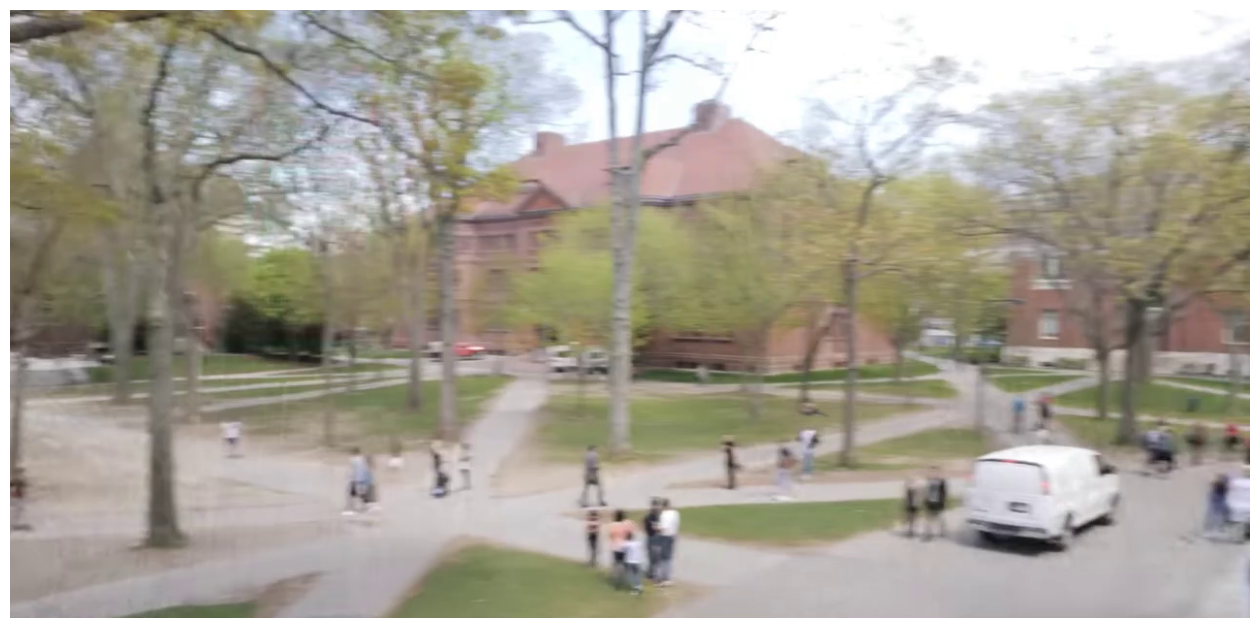

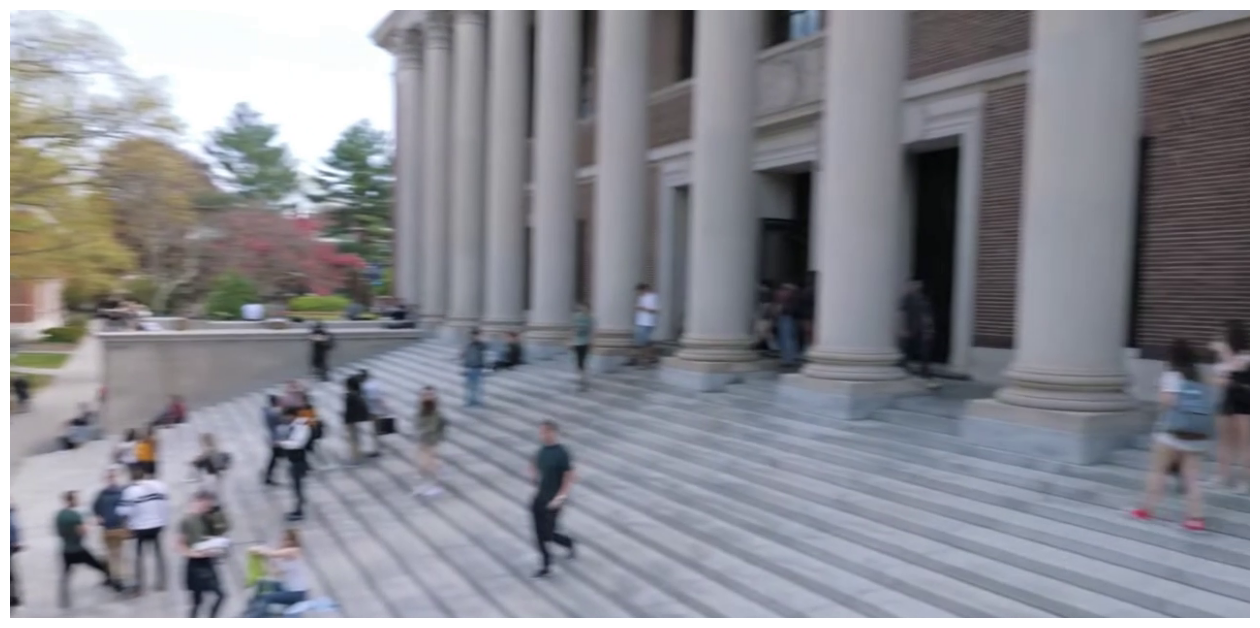

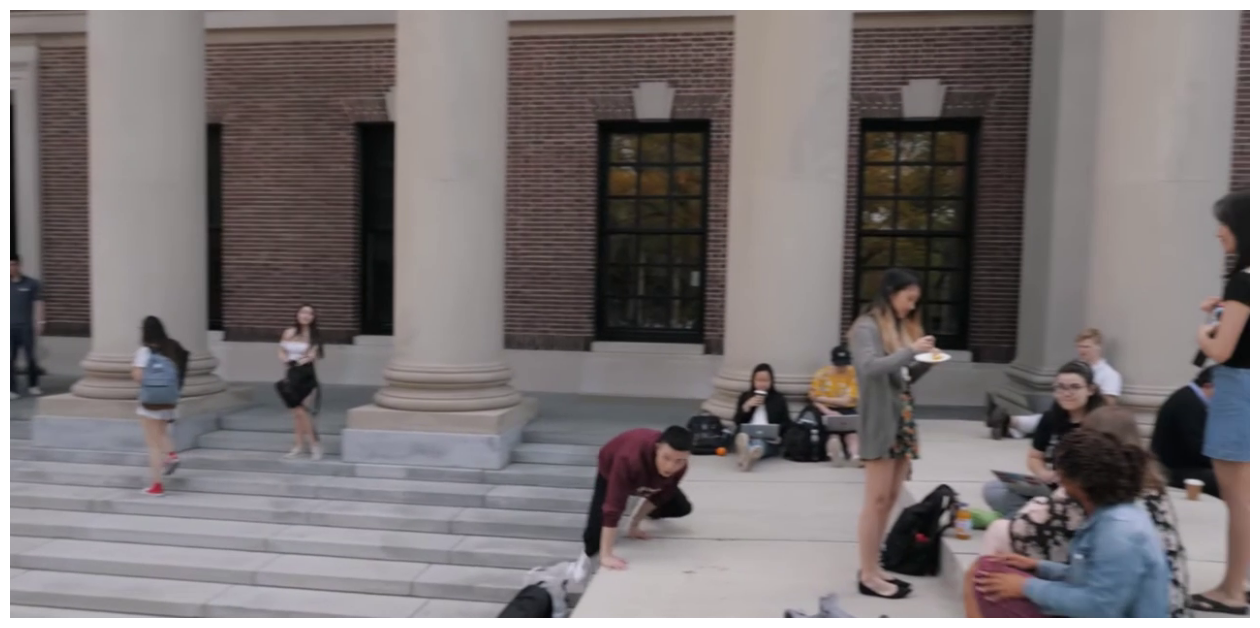

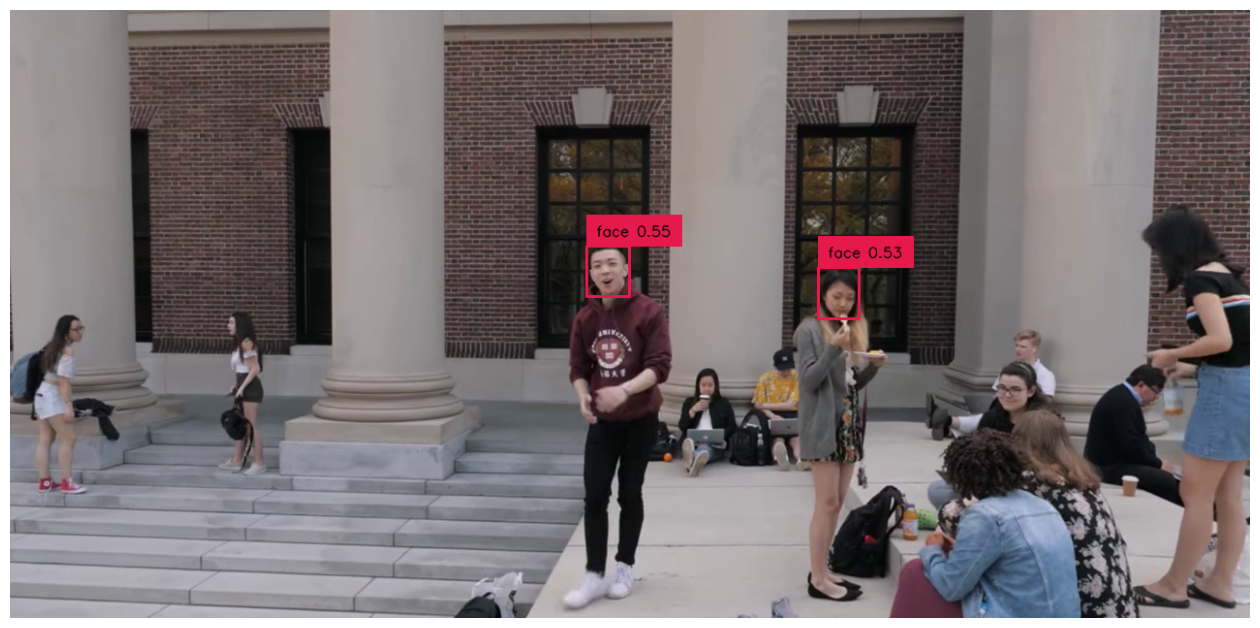

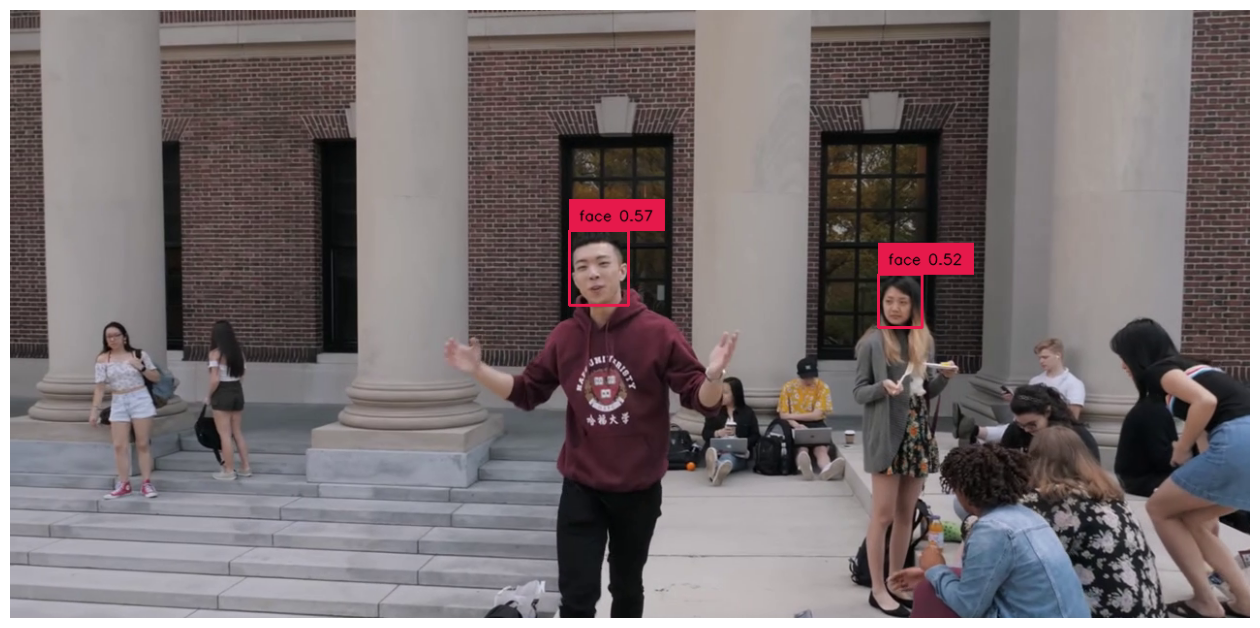

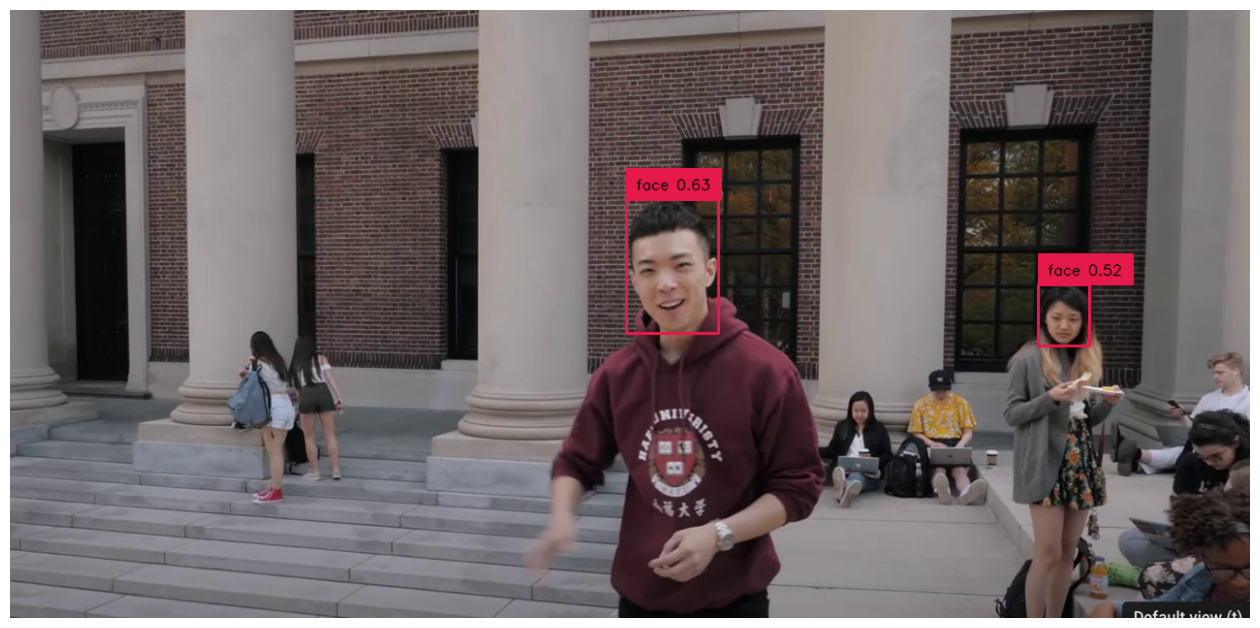

[[0, 0, 0, 0.55, 0.57, 0.63]]


([0 [],
  1 [],
  2 [],
  3 [],
  4 ['head'],
  5 [],
  6 ['head'],
  7 [],
  8 ['head'],
  9 []],
 [(0, 1, 1),
  (1, 2, 1),
  (2, 3, 1),
  (3, 4, 0.38),
  (3, 5, 0.62),
  (4, 6, 0.62),
  (5, 6, 0.62),
  (4, 7, 0.38),
  (5, 7, 0.38),
  (6, 8, 0.97),
  (7, 8, 0.97),
  (6, 9, 0.03),
  (7, 9, 0.03)],
 [8 ['head'], 9 []])

In [25]:
def frame2automaton(video_path, props, scale=2, second_per_frame=2):
    video = read_video(video_path, scale=scale, second_per_frame=second_per_frame)
    num_frames = len(video)
    probabilities = get_probabilities(props, video)
    states, transitions, accept_states = build_automaton(props, num_frames, probabilities)
    return states, transitions, accept_states

def annotate(image, detections, classes):
    classes=['face']
    box_annotator = sv.BoxAnnotator()
    labels = [
        f"{classes[class_id] if class_id is not None else None} {confidence:0.2f}"
        for _, _, confidence, class_id, _ in detections
    ]

    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    %matplotlib inline
    sv.plot_image(annotated_frame, (16, 16))

BOX_TRESHOLD = 0.5
TEXT_TRESHOLD = 0.25
scale=1
second_per_frame=2
props = ['face']

# change the path to your own file directory
frame2automaton(cwd + 'data/harvard.mp4', props, scale, second_per_frame)